In [215]:
import pandas as pd
from urllib.request import urlopen  
import os.path as osp
import os
import logging
import zipfile
from glob import glob
logging.getLogger().setLevel('INFO')
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import timedelta
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import time
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from keras import models, layers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras import metrics
from keras.models import load_model

## Helpers

In [49]:
def download_file(url_str, path):
    url = urlopen(url_str)
    output = open(path, 'wb')       
    output.write(url.read())
    output.close()  
    
def extract_file(archive_path, target_dir):
    zip_file = zipfile.ZipFile(archive_path, 'r')
    zip_file.extractall(target_dir)
    zip_file.close()

## Download the dataset

In [3]:
BASE_URL = 'http://tennis-data.co.uk'
DATA_DIR = "tennis_data"
ATP_DIR = './{}/ATP'.format(DATA_DIR)
WTA_DIR = './{}/WTA'.format(DATA_DIR)

ATP_URLS = [BASE_URL + "/%i/%i.zip" % (i,i) for i in range(2000,2019)]
WTA_URLS = [BASE_URL + "/%iw/%i.zip" % (i,i) for i in range(2007,2019)]

os.makedirs(osp.join(ATP_DIR, 'archives'), exist_ok=True)
os.makedirs(osp.join(WTA_DIR, 'archives'), exist_ok=True)

for files, directory in ((ATP_URLS, ATP_DIR), (WTA_URLS, WTA_DIR)):
    for dl_path in files:
        logging.info("downloading & extracting file %s", dl_path)
        archive_path = osp.join(directory, 'archives', osp.basename(dl_path))
        download_file(dl_path, archive_path)
        extract_file(archive_path, directory)
    
ATP_FILES = sorted(glob("%s/*.xls*" % ATP_DIR))
WTA_FILES = sorted(glob("%s/*.xls*" % WTA_DIR))

df_atp = pd.concat([pd.read_excel(f) for f in ATP_FILES], ignore_index=True)
df_wta = pd.concat([pd.read_excel(f) for f in WTA_FILES], ignore_index=True)

logging.info("%i matches ATP in df_atp", df_atp.shape[0])
logging.info("%i matches WTA in df_wta", df_wta.shape[0])

INFO:root:downloading & extracting file http://tennis-data.co.uk/2000/2000.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2001/2001.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2002/2002.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2003/2003.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2004/2004.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2005/2005.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2006/2006.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2007/2007.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2008/2008.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2009/2009.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2010/2010.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2011/2011.zip
INFO:root:downloading & extracting file http://tenni

# Questions 

#### Question 1 : Who are the three ATP players with the most wins ?


In [4]:
# groupby : Creates groups each holding rows with unique value of the winner
# size    : Returns size of each group
# sort_values : Sorts the Panda Series in descending order
top_winners=df_atp.groupby(['Winner']).size().reset_index(name='count_wins').sort_values(by=['count_wins'],ascending=False)
top_winners.head(3)

,Winner,count_wins
245,Federer R.,1121
588,Nadal R.,891
201,Djokovic N.,802


#### Question 2 : How many sets did the player “Federer R.” win in total ?
The result will be the sum of sets won when Federer is the winner of the match and the sets won when Federer is the looser of the match 

In [6]:
federer_victories = df_atp[df_atp["Winner"].str.contains('Federer R.')]
sets_won_match_won = federer_victories["Wsets"].sum()
sets_won_match_won

2554.0

In [7]:
df_atp["Lsets"] = df_atp["Lsets"].replace("`1", 1)
federer_losses = df_atp[df_atp["Loser"].str.contains('Federer R.')]
sets_won_match_lost = federer_losses["Lsets"].astype(float).sum()
sets_won_match_lost

151.0

In [8]:
total_won_sets=sets_won_match_lost+sets_won_match_won

In [9]:
print('The total number of sets won by Federer R. whether he is the loser or the winner of the match is ', int(total_won_sets))

The total number of sets won by Federer R. whether he is the loser or the winner of the match is  2705


#### Question 3 :  How many sets did the player “​ Federer R.” win during the years 2016 and 2017 ?

In [10]:
sets_won_2016_2017 = federer_victories[(federer_victories["Date"].dt.year == 2016) | (federer_victories["Date"].dt.year == 2017)]["Wsets"].sum()
sets_won_2016_2017 = int(sets_won_2016_2017)
sets_won_2016_2017

172

#### Question 4 : For each match, what is the percentage of victories of the winner in the past ?

In [11]:
def past_victories(df, player):
    """
    For each match, return the percentage of victories of the winner player in the past.
    """

    vic_pers = []
    for i in df[1::].index:
        name = df.loc[i, player]
        df_past = df.iloc[0:i]
        vic_per = df_past[df_past.Winner == name].count().ATP/len(df_past)*100
        vic_pers.append(vic_per)

    vic_pers = [0.0] + vic_pers

    return vic_pers

In [12]:
# Past victories percentage calculated for both  winner and loser because we will be needing it in feature engeneering part
win_pers = past_victories(df_atp, player='Winner')
los_pers = past_victories(df_atp, player='Loser')

In [13]:
df_atp["winner_prior_wins"] = win_pers
df_atp["loser_prior_wins"]= los_pers

In [253]:
df_atp[["Winner","Loser","winner_prior_wins","loser_prior_wins"]]

,Winner,Loser,winner_prior_wins,loser_prior_wins
0,Dosedel S.,Ljubicic I.,0.000000,0.000000
1,Enqvist T.,Clement A.,0.000000,0.000000
2,Escude N.,Baccanello P.,0.000000,0.000000
3,Federer R.,Knippschild J.,0.000000,0.000000
4,Fromberg R.,Woodbridge T.,0.000000,0.000000
...,...,...,...,...
52293,Zverev A.,Isner J.,0.321267,0.713289
52294,Djokovic N.,Cilic M.,1.529812,0.852870
52295,Zverev A.,Federer R.,0.323167,2.143608
52296,Djokovic N.,Anderson K.,1.531666,0.596604


# Defining the problem
##### Input: ATP match information between the year 2000 and 2019

##### Output: predict match result of 2017

Type of the problem : Predicting the outcomes of sport matches is known as a classification problem. If a match is played between player 1 and player 2, then the problem can be formulated as classifying player1 as a winner or a loser. So it's a binary classification problem.


We set Player 1 as the player who's name alphabetically comes first.

Then, we set the labels as :

1 -> if Player 1 wins
0 -> if Player 1 loses

In [14]:
df_atp["Labels"] = df_atp.apply(lambda row: 1 if row["Winner"] < row["Loser"] else 0, axis=1)
display(df_atp[["Winner", "Loser", "Labels"]].head(5))

,Winner,Loser,Labels
0,Dosedel S.,Ljubicic I.,1
1,Enqvist T.,Clement A.,0
2,Escude N.,Baccanello P.,0
3,Federer R.,Knippschild J.,1
4,Fromberg R.,Woodbridge T.,1


In [15]:
df_atp[df_atp["Labels"] == 1].shape[0]

26602

In [16]:
df_atp[df_atp["Labels"]==0].shape[0]

25696

##### The number of targets 0 is 25696 and the number of targets 1 is 26602 . So the dataset is balanced 

# Data preparation process

#### Clean data
We have noticed preceedly that columns of type object(string) such as Ltsets should be nummerical numbers. 
So there might be some errors and that after executing df_atp.describe(), we did not see these comlumns.

In [17]:
# columns of which the data type is 'object' (string)
print([col for col in df_atp.columns if df_atp[str(col)].dtypes == 'object'])

['Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round', 'Winner', 'Loser', 'WRank', 'LRank', 'W2', 'L2', 'W3', 'L3', 'Comment', 'EXW']


In [18]:
#find out the erros for nummerical columns
for column in ['EXW', 'WRank', 'LRank', 'L2', 'W2', 'L3','W3']:
    print(column,':' ,[x for x in df_atp[str(column)] if type(x)==str])

EXW : ['2.,3']
WRank : ['NR']
LRank : ['NR', 'NR', 'NR', 'NR', 'NR', 'NR', 'NR', 'NR', 'NR', 'NR', 'NR', 'NR', 'NR', 'NR', 'NR', 'NR', 'NR', 'NR', 'NR', 'NR', 'NR', 'NR', 'NR', 'NR', 'NR', 'NR', 'NR']
L2 : [' ', ' ']
W2 : [' ', ' ']
L3 : [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
W3 : [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 

In [100]:
df_atp_cleaned = df_atp.copy()
df_atp_cleaned["EXW"] = df_atp_cleaned["EXW"].replace("2.,3", 2.3)
df_atp_cleaned["LRank"] = df_atp_cleaned["LRank"].replace("NR", np.nan).astype('float')
df_atp_cleaned["WRank"] = df_atp_cleaned["WRank"].replace("NR", np.nan).astype('float')
df_atp_cleaned["L2"] = df_atp_cleaned["L2"].replace(' ', np.nan)
df_atp_cleaned["W2"] = df_atp_cleaned["W2"].replace(' ', np.nan)
df_atp_cleaned["L3"] = df_atp_cleaned["L3"].replace(' ', np.nan)
df_atp_cleaned["W3"] = df_atp_cleaned["W3"].replace(' ', np.nan)

In [101]:
df_atp_cleaned.describe()

,ATP,Best of,WRank,LRank,W1,L1,W2,L2,W3,L3,...,LBL,SJW,SJL,MaxW,MaxL,AvgW,AvgL,winner_prior_wins,loser_prior_wins,Labels
count,52298.000000,52298.000000,52282.000000,52193.000000,52035.000000,52037.000000,51524.000000,51525.000000,24070.000000,24070.000000,...,28142.000000,15572.000000,15579.000000,22745.000000,22745.000000,22745.000000,22745.000000,52298.000000,52298.000000,52298.000000
mean,33.222532,3.372366,59.172564,92.227042,5.794331,4.056229,5.772824,3.872664,6.025052,3.607104,...,3.451461,1.796538,3.557943,1.998610,8.326076,1.834821,3.594448,0.608667,0.426533,0.508662
std,18.115493,0.778516,73.614866,116.947845,1.239577,1.845206,1.256545,1.874537,0.932111,1.767365,...,3.075889,1.004273,3.272510,1.628982,397.235666,1.107884,3.282610,0.540623,0.453331,0.499930
min,1.000000,3.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.010000,1.010000,1.010000,1.010000,1.010000,0.000000,0.000000,0.000000
25%,19.000000,3.000000,17.000000,35.000000,6.000000,3.000000,6.000000,2.000000,6.000000,2.000000,...,1.730000,1.220000,1.730000,1.290000,1.850000,1.240000,1.740000,0.161765,0.075110,0.000000
50%,33.000000,3.000000,41.000000,65.000000,6.000000,4.000000,6.000000,4.000000,6.000000,4.000000,...,2.500000,1.500000,2.630000,1.570000,2.780000,1.500000,2.550000,0.501268,0.268616,1.000000
75%,49.000000,3.000000,77.000000,105.000000,6.000000,6.000000,6.000000,6.000000,6.000000,5.000000,...,4.000000,2.000000,4.000000,2.200000,4.540000,2.060000,3.990000,0.909962,0.680616,1.000000
max,69.000000,5.000000,1890.000000,2159.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,...,51.000000,19.000000,81.000000,76.000000,42586.000000,23.450000,36.440000,13.333333,13.333333,1.000000


#### Check missing values

In [102]:
columns_with_missing_values = df_atp_cleaned.columns[df_atp_cleaned.isnull().any()]
df_atp_cleaned[columns_with_missing_values].isnull().sum().sort_values(ascending=False)

B&WW     51201
B&WL     51201
W5       50507
L5       50507
W4       47567
L4       47567
GBW      47243
GBL      47243
SBW      46874
SBL      46874
UBW      41627
UBL      41627
IWW      38940
IWL      38940
SJW      36726
SJL      36719
CBL      34792
CBW      34792
AvgW     29553
AvgL     29553
MaxW     29553
MaxL     29553
W3       28228
L3       28228
LBW      24167
LBL      24156
LPts     16263
WPts     16204
PSW      14959
PSL      14959
EXW      12887
EXL      12882
B365W     8655
B365L     8632
W2         774
L2         773
W1         263
L1         261
Lsets      225
Wsets      224
LRank      105
WRank       16
dtype: int64

Text(0.5, 1.0, 'Variables with missing values')

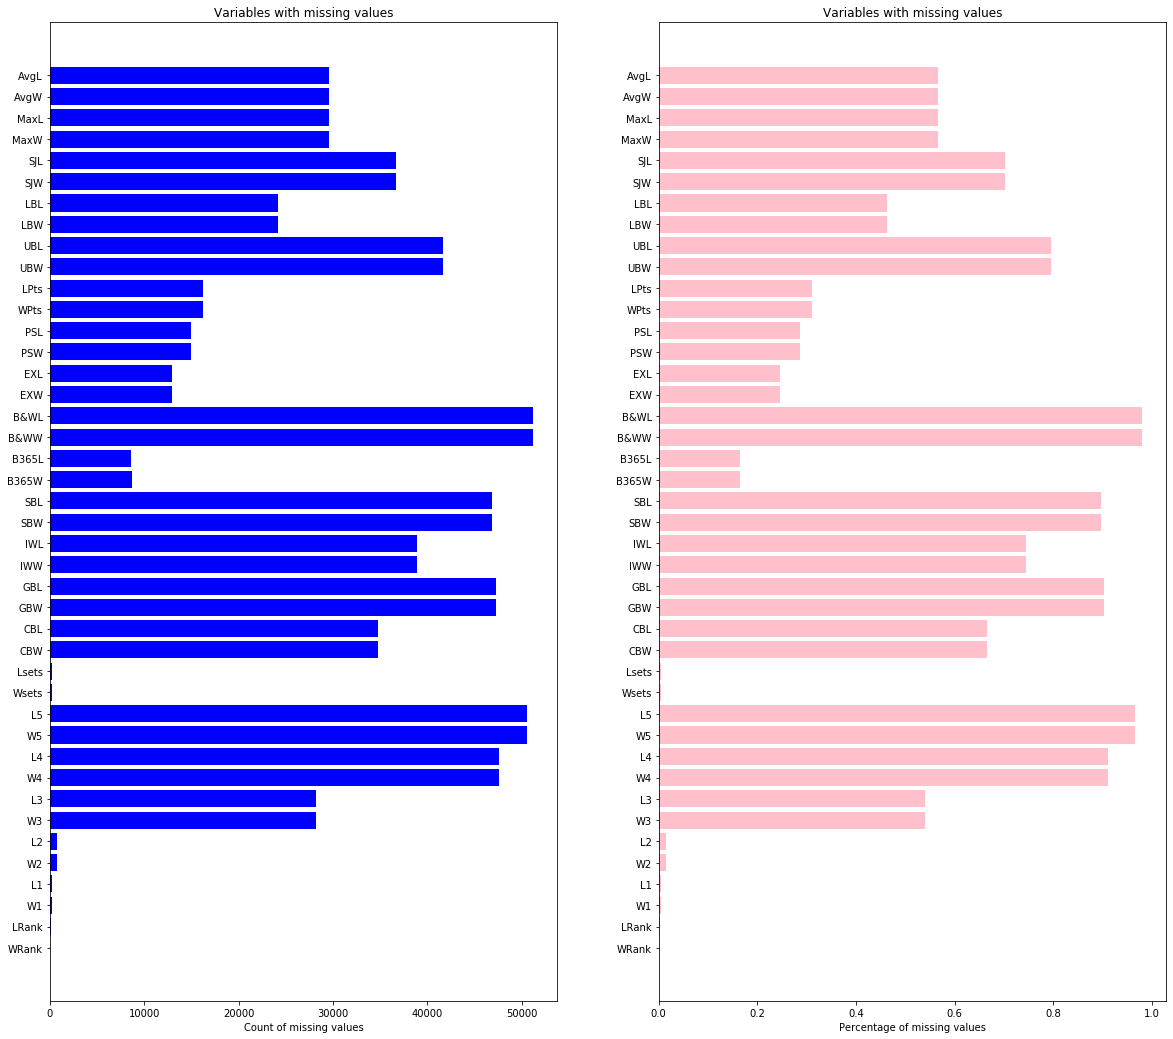

In [103]:
# To hold variable names
labels = [] 

# To hold the count of missing values for each variable 
valuecount = [] 

# To hold the percentage of missing values for each variable
percentcount = [] 

for col in columns_with_missing_values:
    labels.append(col)
    valuecount.append(df_atp_cleaned[col].isnull().sum())
    percentcount.append(df_atp_cleaned[col].isnull().sum()/df_atp_cleaned.shape[0])

ind = np.arange(len(labels))

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,18))

rects = ax1.barh(ind, np.array(valuecount), color='blue')
ax1.set_yticks(ind)
ax1.set_yticklabels(labels, rotation='horizontal')
ax1.set_xlabel("Count of missing values")
ax1.set_title("Variables with missing values")

rects = ax2.barh(ind, np.array(percentcount), color='pink')
ax2.set_yticks(ind)
ax2.set_yticklabels(labels, rotation='horizontal')
ax2.set_xlabel("Percentage of missing values")
ax2.set_title("Variables with missing values")

###### We can notice that most of the missing values are in the columns concerning odds where more than 80% of data is missing. The columns without missing values are :ATP, Location, Tournament, Date, Series, Court, Surface, Round, Best of, Winner, Loser and Comment

In [104]:
def getting_absent_features(labels,percentcounts):
    """getting features having more than 80% of missing values"""
    features=[]
    for i in range(len(labels)):
        if percentcounts[i]>=0.8:
            features.append(labels[i])
    return features

In [105]:
features_to_drop=getting_absent_features(labels,percentcount)
print("Features having more than 80% missing values are",features_to_drop )

Features having more than 80% missing values are ['W4', 'L4', 'W5', 'L5', 'GBW', 'GBL', 'SBW', 'SBL', 'B&WW', 'B&WL']


#### Dealing with missing values

1- Drop columns having more than 80% of missing values
 
2- Only keep the information that can be available before match . So features like match score ("L1, L2, L3, L4, L5, W1, W2, W3, W4, W5,Comment,Lsets,Wsets) cannot be used directly. Lsets and Wsets , Winner and loser are kept for feature generation

Remarque:  Lsets, Wsets will be kept , we will use them for generating features then they will be droped 

2-For the rest of odds, we replace NaNs by a value of 1.0 which corresponds to a winning probability of 50% 

3-For number of games won by set,Wsets and Lsets, we replace NaNs by zeros

4-For ranking replace NR by the largest ranking value


In [106]:
#Drop features having more than 80% of missing values 
df_atp_cleaned=df_atp_cleaned.drop(features_to_drop,axis=1)

#Drop features intuitively irrelevant 
"""Match 'Location' and tournament are not used for training, since this is not an important feature. The players' performace isn't impacted much by the location of the match. This is prouved by trying taking into account or not these features.
    The prediction accuracy almost doesn't change."""
df_atp_cleaned=df_atp_cleaned.drop(['ATP','Location','Tournament','WPts','LPts'],axis=1)

#Drop features not available before the match (Winner , Loser , Lsets, Wsets  are kept for feature generation done below)
df_atp_cleaned=df_atp_cleaned.drop(['L1', 'L2', 'L3', 'W1', 'W2', 'W3','Comment'],axis=1)

#Filling missing values
df_atp_cleaned.fillna({x : 1.0 for x in [
    "AvgL", "AvgW", "B365L", "B365W", "CBL", "CBW", "EXL", "EXW", "IWL", "IWW",
    "LBL", "LBW", "MaxL", "MaxW", "PSL", "PSW", "SJL", "SJW", "UBL", "UBW"
]}, inplace=True)

df_atp_cleaned.fillna({x : 0 for x in ["Lsets", "Wsets"]}, inplace=True)

df_atp_cleaned["WRank"] = df_atp_cleaned["WRank"].fillna(df_atp_cleaned["WRank"].max())
df_atp_cleaned["LRank"] = df_atp_cleaned["LRank"].fillna(df_atp_cleaned["LRank"].max())



#### Transform 
For categorical features, encoding is necessary for all the machine learning algorithms.

In [107]:
def categorical_features_encoding(cat_features):
    """
    Categorical features encoding.
    Simple one-hot encoding.
    """
  
    ohe = OneHotEncoder()
    cat_features_encoded = ohe.fit_transform(cat_features)
    columns = ohe.get_feature_names(list(cat_features.columns))
    cat_features = pd.DataFrame(cat_features_encoded.todense(), columns=columns)

    return cat_features

In [108]:
categories= ['Best of', 'Court', 'Round', 'Series', 'Surface']
df_categories=df_atp_cleaned[categories]
features_encoded=categorical_features_encoding(df_categories)

In [109]:
df_atp_cleaned_encoded=pd.concat([features_encoded,df_atp_cleaned.drop(categories,axis=1)],axis=1)

#### Observations

In [110]:
df_atp3=df_atp.copy()
df_atp3['year'] = df_atp3.Date.apply(lambda x: x.year)
col_odds = ['AvgL', 'AvgW', 'B&WL', 'B&WW', 'B365L', 'B365W', 'CBL', 'CBW', 'EXL', 'EXW',
             'GBL', 'GBW', 'IWL', 'IWW', 'LBL', 'LBW', 'MaxL', 'MaxW', 'PSL', 'PSW',
             'SBL', 'SBW', 'SJL', 'SJW', 'UBL', 'UBW']
df_atp3[col_odds + ['year']].groupby('year').count()

,AvgL,AvgW,B&WL,B&WW,B365L,B365W,CBL,CBW,EXL,EXW,...,MaxL,MaxW,PSL,PSW,SBL,SBW,SJL,SJW,UBL,UBW
year,,,,,,,,,,,,,,,,,,,,,
2000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2001,0,0,0,0,0,0,2415,2415,0,0,...,0,0,0,0,1967,1967,0,0,0,0
2002,0,0,39,39,1201,1201,2433,2433,0,0,...,0,0,0,0,1250,1250,0,0,0,0
2003,0,0,1058,1058,2594,2594,1986,1986,0,0,...,0,0,0,0,2207,2207,0,0,0,0
2004,0,0,0,0,2602,2602,2619,2619,2631,2631,...,0,0,2698,2698,0,0,0,0,0,0
2005,0,0,0,0,2759,2759,2700,2700,2717,2717,...,0,0,2817,2817,0,0,0,0,1,1
2006,0,0,0,0,2771,2771,2725,2725,2731,2731,...,0,0,2834,2834,0,0,0,0,2703,2703
2007,0,0,0,0,2742,2742,2628,2628,2636,2636,...,0,0,2768,2768,0,0,0,0,2675,2675
2008,0,0,0,0,2652,2652,0,0,2565,2565,...,0,0,2641,2641,0,0,0,0,2606,2606


###### We can notice that half the odds columns do not have data before 2010. It would be interesting to see how some elements, such as odds, atp entry ranking, and entry points can help to do the prediction alone for observations after 2010 

In [111]:
import datetime

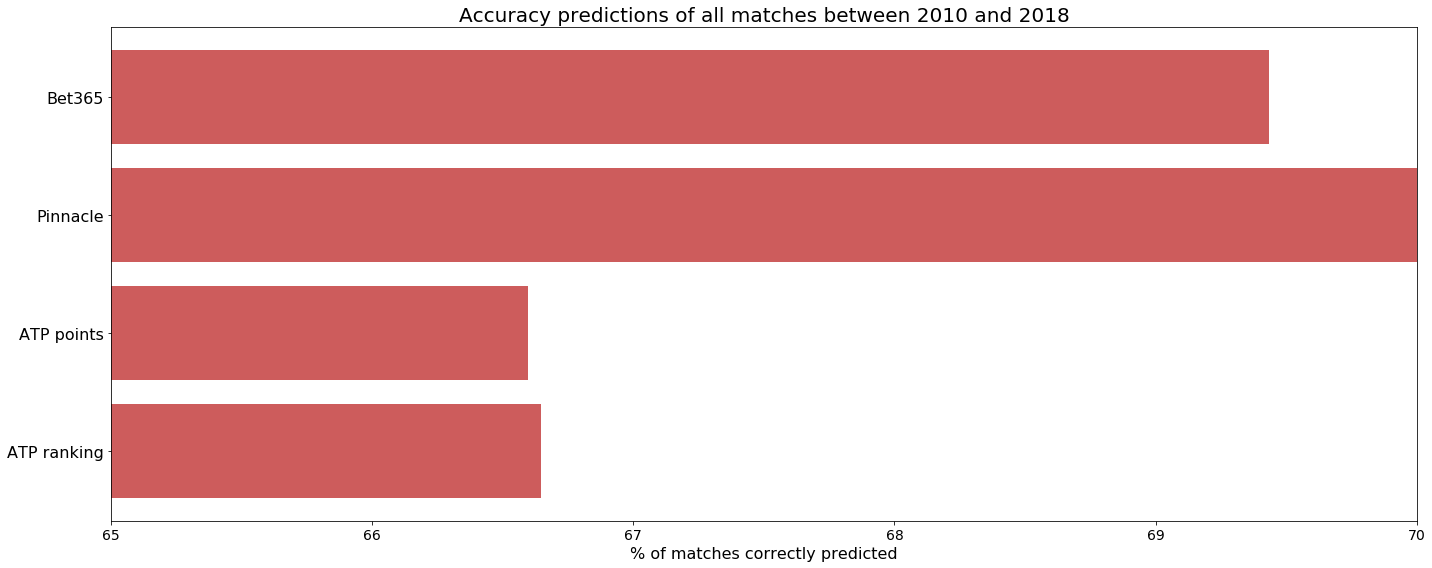

In [112]:
# replace NR by the largest ranking value
df_atp3['WRank'] = df_atp3.WRank.replace('NR', df_atp3.WRank.replace('NR', np.nan).max())
df_atp3['LRank'] = df_atp3.LRank.replace('NR', df_atp3.LRank.replace('NR', np.nan).max())

# select a subset of data
start = datetime.datetime(2010,1,1)
end = datetime.datetime(2018,1,1)
idx = df_atp3[(df_atp3.Date>=start)&(df_atp3.Date<=end)].index
test = df_atp3.iloc[idx,:]

# classical ATP ranking
atp_rank = 100*(test.WRank<test.LRank).sum()/len(idx)

# ATP Entry points
atp_pts = 100*(test.WPts>test.LPts).sum()/len(idx)

# Bookmakers
book_pi = 100*(test.PSW<test.PSL).sum()/len(idx)
book_365 = 100*(test.B365W<test.B365L).sum()/len(idx)


# Plot

labels = ["ATP ranking", "ATP points", "Pinnacle", "Bet365"]
values = [atp_rank, atp_pts, book_pi, book_365]
y_pos = np.arange(len(labels))

fig = plt.figure(figsize=(20,8))
plt.barh(y_pos, values,color='indianred')

plt.yticks(y_pos, labels, fontsize=16)
plt.xticks(fontsize=14)
plt.xlabel('% of matches correctly predicted', fontsize=16)
plt.title("Accuracy predictions of all matches between 2010 and 2018",
         fontsize=20)
plt.xlim([65,70])
plt.tight_layout()

plt.show()



From the figure above we can see that Pinnacle and Bet365 odds can be  good predictors.


#### Feature generation

The historical information before the match can be used to reflect the performance of the players. We will be using for exemple the result of Question 4 for this purpose and the historical mean value of: ATP Rank of each player, Wsets, Lsets, PSW, PSL, B365W, B365L . For odds information, since generally it is not known before the match, it is not used directly as features. Except for Bet365 and Pinnacle wich are good predictors . 

In [113]:
from datetime import timedelta  

In [114]:
def get_historical_mean_rank_player(df, delta_time_in_days, as_winner_col_interest, as_loser_col_interest, col_output):
    """
    For each match, return the mean value of past x days (delta_time_in_days) for column 
    in question of each player. For examle, if col_pair_interest is ('WRank', 'LRank'), and
    delta_time_in_days is 180, this function returns a dataframe with two columns (Winner_hist_mean_rank, Loser_hist_mean_rank)
    of which each row indicates the mean values of ATP Rank of the player (Winner) 
    in the past 180 days and that of the player (Loser).
    """
    Winner_hist_mean_interest = []
    Loser_hist_mean_interest = []
    
    for [winner,loser,date] in df[["Winner","Loser","Date"]].values:
        
        df_hist = df[(df["Date"] > date-timedelta(days=delta_time_in_days)) & (df["Date"] < date)]
        
        df_hist_rank_winner_as_winner = df_hist[df_hist["Winner"]==winner][as_winner_col_interest].values
        df_hist_rank_winner_as_loser = df_hist[df_hist["Loser"]==winner][as_loser_col_interest].values
        
        df_hist_rank_loser_as_winner = df_hist[df_hist["Winner"]==loser][as_winner_col_interest].values
        df_hist_rank_loser_as_loser = df_hist[df_hist["Loser"]==loser][as_loser_col_interest].values
        
        all_hist_rank_Winner =  np.append(df_hist_rank_winner_as_winner,df_hist_rank_winner_as_loser)
        all_hist_rank_Loser =  np.append(df_hist_rank_loser_as_winner,df_hist_rank_loser_as_loser)
        
        Winner_hist_mean_interest.append( np.nanmean(all_hist_rank_Winner) if(len(all_hist_rank_Winner) > 0) else np.nan)
        Loser_hist_mean_interest.append( np.nanmean(all_hist_rank_Loser) if(len(all_hist_rank_Loser) > 0) else np.nan)
    
    df["Winner_hist_mean_"+col_output]= Winner_hist_mean_interest
    df["Loser_hist_mean_"+col_output]= Loser_hist_mean_interest
    return df

In [115]:
df_atp_cleaned_modified = get_historical_mean_rank_player(df_atp_cleaned_encoded,90,"WRank","LRank","Rank")
df_atp_cleaned_modified = get_historical_mean_rank_player(df_atp_cleaned_modified,90,"Wsets","Lsets","Wset")
df_atp_cleaned_modified=df_atp_cleaned_modified.dropna()

We can see that, generally, winners have smaller odds, smaller ranks and larger points. So we can build some features according to these patterns. Notably, the odds difference, point difference and rank difference between the winner and the loser.
In fact, any effective tennis prediction model must consider the characteristics of both players participating in
a match. Consequently, we must have two values for each variable of interest, one for each player. We
construct a feature by taking the difference between these two values. For example, consider a simple
model based only on the ATP ranks of the two players. In this case, we construct a single feature
RANK = RANK1 − RANK2, where RANK1 and RANK2 are the ranks of players 1 and 2 at the time
of the match, respectively

In [117]:
def cal_diff(df, col_pair,output_name):
    """
    Return the numerical difference between the two columns in col_pairs, 
    and store the values in a dataframe.
    """
    dic = {}
    col_win,col_los=col_pair
    dic[output_name] = abs(df[str(col_win)] - df[str(col_los)])
    df_diff = pd.DataFrame(data=dic, columns=dic.keys())

    return df_diff

In [118]:
vic_diff = cal_diff(df_atp_cleaned_modified, ('winner_prior_wins', 'loser_prior_wins'),'diff_win')
bet365_diff=cal_diff(df_atp_cleaned_modified, ('B365W', 'B365L'),'diff_b365')
rank_diff=cal_diff(df_atp_cleaned_modified, ('WRank', 'LRank'),'diff_rank')
pinnacle_diff=cal_diff(df_atp_cleaned_modified, ('PSW', 'PSL'),'diff_pinnacle')

In [119]:
df_atp_cleaned_modified=pd.concat([df_atp_cleaned_modified,vic_diff,bet365_diff,rank_diff,pinnacle_diff],axis=1)

#### Normalize data 

In [121]:
#Standardize the Data
numerical_features=['WRank', 'LRank', 'CBW', 'CBL', 'IWW', 'IWL',
       'B365W', 'B365L', 'EXW', 'EXL', 'PSW', 'PSL', 'UBW', 'UBL', 'LBW',
       'LBL', 'SJW', 'SJL', 'MaxW', 'MaxL', 'AvgW', 'AvgL',
       'winner_prior_wins', 'loser_prior_wins',
       'Winner_hist_mean_Rank', 'Loser_hist_mean_Rank',
       'Winner_hist_mean_Wset', 'Loser_hist_mean_Wset','diff_win','diff_b365','diff_rank','diff_pinnacle']
# Separating out the features
X = df_atp_cleaned_modified[numerical_features]
# Separating out the target
y = df_atp_cleaned_modified['Labels']
# Standardizing the features
X = StandardScaler().fit_transform(X)
numerical_features_normalized=pd.DataFrame(X,columns=numerical_features)
numerical_features_normalized

,WRank,LRank,CBW,CBL,IWW,IWL,B365W,B365L,EXW,EXL,...,winner_prior_wins,loser_prior_wins,Winner_hist_mean_Rank,Loser_hist_mean_Rank,Winner_hist_mean_Wset,Loser_hist_mean_Wset,diff_win,diff_b365,diff_rank,diff_pinnacle
0,2.558462,-0.308898,-0.442564,-0.45347,-0.419814,-0.444141,-0.670843,-0.647588,-0.688688,-0.736983,...,-1.212600,1.428524,2.045305,-0.301081,-3.116556,0.489215,1.465539,-0.648718,1.155025,-0.462618
1,1.015184,0.211238,-0.442564,-0.45347,-0.419814,-0.444141,-0.670843,-0.647588,-0.688688,-0.736983,...,0.815822,8.746713,0.760686,0.468579,0.236935,1.119733,6.622653,-0.648718,-0.426201,-0.462618
2,0.082787,0.041628,-0.442564,-0.45347,-0.419814,-0.444141,-0.670843,-0.647588,-0.688688,-0.736983,...,0.753087,1.326483,0.030216,0.010680,0.236935,-0.561647,-1.154832,-0.648718,-0.392794,-0.462618
3,-0.061895,-0.195825,-0.442564,-0.45347,-0.419814,-0.444141,-0.670843,-0.647588,-0.688688,-0.736983,...,2.526060,1.210186,-0.007567,-0.193913,-0.135675,-0.561647,1.234330,-0.648718,-0.526419,-0.462618
4,-0.238729,-0.094059,-0.442564,-0.45347,-0.419814,-0.444141,-0.670843,-0.647588,-0.688688,-0.736983,...,2.384978,-1.045972,-0.146105,-0.174428,-0.135675,-2.663372,3.443178,-0.648718,-0.303711,-0.462618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46602,-0.753155,-0.749884,-0.442564,-0.45347,-0.419814,-0.444141,-0.328087,0.021292,-0.267065,0.293800,...,-0.600035,0.595505,-0.639382,-0.680343,0.485341,0.939585,-0.199496,-0.097134,-0.593231,-0.096155
46603,-0.817458,-0.783806,-0.442564,-0.45347,-0.419814,-0.444141,-0.480423,0.416540,-0.477876,1.195735,...,1.704318,0.916722,-0.650507,-0.713050,1.801897,0.939585,0.494838,0.340536,-0.582096,0.348836
46604,-0.753155,-0.829035,-0.442564,-0.45347,-0.419814,-0.444141,1.423778,-0.538135,1.752285,-0.556596,...,-0.596413,3.887073,-0.639271,-0.753134,0.531101,1.014646,3.281485,-0.097134,-0.626638,-0.094142
46605,-0.817458,-0.795113,-0.442564,-0.45347,-0.419814,-0.444141,-0.566112,1.176631,-0.533353,1.839975,...,1.707852,0.326981,-0.656174,-0.709779,1.801897,0.489215,1.123863,1.116949,-0.593231,0.866314


####  Feature selection

In [122]:
df_atp_cleaned_modified_no_index=df_atp_cleaned_modified.reset_index(drop=True)
data_normalized=df_atp_cleaned_modified_no_index.drop(['Winner','Loser','Lsets','Wsets']+numerical_features,axis=1)
data_normalized[numerical_features]=numerical_features_normalized

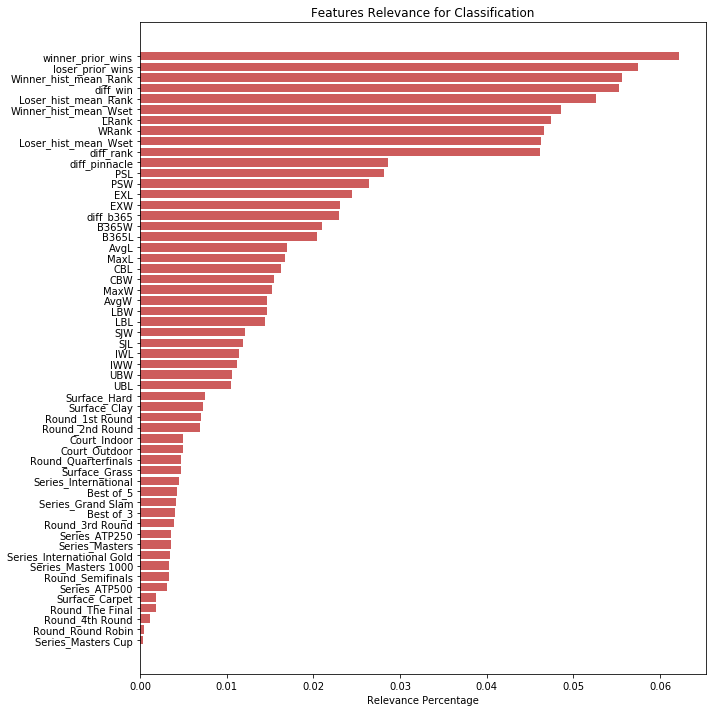

In [123]:
from sklearn.ensemble import RandomForestClassifier
feat_forest = RandomForestClassifier(n_jobs=-1)
feat_forest.fit(X=data_normalized.drop(["Labels","Date"], axis=1), y=data_normalized["Labels"])
plt.figure(figsize=(10, 10))
feat_imp = feat_forest.feature_importances_
cols = data_normalized.drop(["Labels","Date"],axis=1).columns
    
feat_imp, cols = zip(*sorted(zip(feat_imp, cols)))

plt.barh(range(len(cols)), feat_imp, align="center", color='indianred');
plt.yticks(range(len(cols)), cols)
plt.title("Features Relevance for Classification")
plt.xlabel("Relevance Percentage")
plt.tight_layout()

We can observe that only principal components wich are numerical features are relevant. Categorical features such as Round, Surface, Court are not relevant

In [124]:
relevance_threshold = 0.02
feat_imp = np.array(feat_imp)
most_relevante_feat = cols[- np.where(feat_imp > relevance_threshold)[0].shape[0] :]
most_relevante_feat

('B365L',
 'B365W',
 'diff_b365',
 'EXW',
 'EXL',
 'PSW',
 'PSL',
 'diff_pinnacle',
 'diff_rank',
 'Loser_hist_mean_Wset',
 'WRank',
 'LRank',
 'Winner_hist_mean_Wset',
 'Loser_hist_mean_Rank',
 'diff_win',
 'Winner_hist_mean_Rank',
 'loser_prior_wins',
 'winner_prior_wins')

# Modeling Phase 

##### Splitting the dataset to train / test datasets

In [125]:
data_modeling=data_normalized[list(most_relevante_feat)+['Labels','Date']]
data_modeling

,B365L,B365W,diff_b365,EXW,EXL,PSW,PSL,diff_pinnacle,diff_rank,Loser_hist_mean_Wset,WRank,LRank,Winner_hist_mean_Wset,Loser_hist_mean_Rank,diff_win,Winner_hist_mean_Rank,loser_prior_wins,winner_prior_wins,Labels,Date
0,-0.647588,-0.670843,-0.648718,-0.688688,-0.736983,-0.560808,-0.462794,-0.462618,1.155025,0.489215,2.558462,-0.308898,-3.116556,-0.301081,1.465539,2.045305,1.428524,-1.212600,1,2000-01-10
1,-0.647588,-0.670843,-0.648718,-0.688688,-0.736983,-0.560808,-0.462794,-0.462618,-0.426201,1.119733,1.015184,0.211238,0.236935,0.468579,6.622653,0.760686,8.746713,0.815822,1,2000-01-10
2,-0.647588,-0.670843,-0.648718,-0.688688,-0.736983,-0.560808,-0.462794,-0.462618,-0.392794,-0.561647,0.082787,0.041628,0.236935,0.010680,-1.154832,0.030216,1.326483,0.753087,0,2000-01-10
3,-0.647588,-0.670843,-0.648718,-0.688688,-0.736983,-0.560808,-0.462794,-0.462618,-0.526419,-0.561647,-0.061895,-0.195825,-0.135675,-0.193913,1.234330,-0.007567,1.210186,2.526060,0,2000-01-10
4,-0.647588,-0.670843,-0.648718,-0.688688,-0.736983,-0.560808,-0.462794,-0.462618,-0.303711,-2.663372,-0.238729,-0.094059,-0.135675,-0.174428,3.443178,-0.146105,-1.045972,2.384978,0,2000-01-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46602,0.021292,-0.328087,-0.097134,-0.267065,0.293800,-0.229434,-0.010862,-0.096155,-0.593231,0.939585,-0.753155,-0.749884,0.485341,-0.680343,-0.199496,-0.639382,0.595505,-0.600035,0,2018-11-16
46603,0.416540,-0.480423,0.340536,-0.477876,1.195735,-0.395121,0.398320,0.348836,-0.582096,0.939585,-0.817458,-0.783806,1.801897,-0.713050,0.494838,-0.650507,0.916722,1.704318,0,2018-11-16
46604,-0.538135,1.423778,-0.097134,1.752285,-0.556596,1.294885,-0.379329,-0.094142,-0.626638,1.014646,-0.753155,-0.829035,0.531101,-0.753134,3.281485,-0.639271,3.887073,-0.596413,0,2018-11-17
46605,1.176631,-0.566112,1.116949,-0.533353,1.839975,-0.461396,0.905216,0.866314,-0.593231,0.489215,-0.817458,-0.795113,1.801897,-0.709779,1.123863,-0.656174,0.326981,1.707852,0,2018-11-17


In [126]:
test_year = 2017

df_train = data_modeling[data_modeling["Date"].dt.year != test_year]
df_test = data_modeling[data_modeling["Date"].dt.year == test_year]

X_train = df_train.drop(["Labels","Date"], axis=1)
y_train = df_train["Labels"]

X_test = df_test.drop(["Labels","Date"], axis=1)
y_test = df_test["Labels"]

#### We will use gridsearch for most well-known classification algorithms : Random Forest ,SVM ,KNN , Xgboost to get best parameters for each and every algorithm using cross validation with 5-fold  than Evaluating  all of them together on train set then test set 

### Decision tree

In [208]:
dt_param_grid = {'max_depth':[4,8,10], 'criterion':['gini', 'entropy'],'min_samples_split': [50,60,65]}

In [209]:
dt=DecisionTreeClassifier(random_state=42)
cross_validation_dt = GridSearchCV(estimator=dt, param_grid=dt_param_grid, cv= 5)
cross_validation_dt.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                     

In [210]:
cross_validation_dt.best_params_

{'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 60}

### Random Forest

In [127]:
rfc_param_grid = { 
    'n_estimators': [20, 40,60],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,8,12],
    'criterion' :['gini', 'entropy'],
    'min_samples_split': [50,60,65]
}

In [128]:
rfc = RandomForestClassifier(n_jobs=-1,random_state=42)
cross_validation_rfc = GridSearchCV(estimator=rfc, param_grid=rfc_param_grid, cv= 5)
cross_validation_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=42,
                                    

In [173]:
cross_validation_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 12,
 'max_features': 'auto',
 'min_samples_split': 50,
 'n_estimators': 40}

### SVM 

In [132]:
svm_param_grid={'C': [ 1, 10],  
              'gamma': [1, 0.1], 
              'kernel': ['rbf','linear','sigmoid']}  

In [134]:
cross_validation_svm = GridSearchCV(SVC(), svm_param_grid,cv= 5) 
cross_validation_svm.fit(X_train, y_train) 
best_svm_prametres=cross_validation_svm.best_params_

In [135]:
best_svm_prametres

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}

### XGboost

In [184]:
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

In [161]:
param_grid = {'max_depth': [2, 3], 
              'learning_rate': [0.1, 0.3], 
              'n_estimators': [50, 100]}

In [162]:
xgb = xgb.XGBClassifier()
clf = GridSearchCV(xgb, param_grid, n_jobs=5,scoring='accuracy', verbose=2, refit=True ,cv=5)
clf.fit(X_train,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   51.7s
[Parallel(n_jobs=5)]: Done  40 out of  40 | elapsed:  1.1min finished
/home/ghada/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:41:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estim...
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     use_label_encoder=True,
  

In [179]:
clf.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}

# Evaluation 

### Decision Tree

In [212]:
dt_best = DecisionTreeClassifier(criterion='entropy',max_depth=8,max_features='auto',min_samples_split=60,random_state=42)
dt_best.fit(X_train,y_train)
y_pred_dt=dt_best.predict(X_test)
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.50      0.48      0.49      1151
           1       0.53      0.55      0.54      1221

    accuracy                           0.52      2372
   macro avg       0.51      0.51      0.51      2372
weighted avg       0.52      0.52      0.52      2372



### Random forest

In [170]:
rfc_best = RandomForestClassifier(criterion='gini',max_depth=12,max_features='auto',min_samples_split=50,n_estimators=68,n_jobs=-1,random_state=42)
rfc_best.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=50,
                       min_weight_fraction_leaf=0.0, n_estimators=68, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [172]:
y_pred=rfc_best.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.50      0.52      1151
           1       0.55      0.58      0.57      1221

    accuracy                           0.54      2372
   macro avg       0.54      0.54      0.54      2372
weighted avg       0.54      0.54      0.54      2372



### SVM

In [196]:
svm_best = SVC()
svm_best.fit(X_train,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [197]:
y_pred_svm=svm_best.predict(X_test)
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.50      0.36      0.42      1151
           1       0.52      0.67      0.59      1221

    accuracy                           0.52      2372
   macro avg       0.51      0.51      0.50      2372
weighted avg       0.51      0.52      0.50      2372



### XGBOOST

In [191]:
xgb_best = xgb.XGBClassifier(learning_rate=0.1,max_depth=3,n_estimators=50)
xgb_best.fit(X_train,y_train)

/home/ghada/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:18:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

In [193]:
y_pred_xgb=xgb_best.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.53      0.50      0.52      1151
           1       0.56      0.58      0.57      1221

    accuracy                           0.55      2372
   macro avg       0.54      0.54      0.54      2372
weighted avg       0.54      0.55      0.54      2372



# Deep learning approach

We thought that a neural network might be useful in discovering non-linearities. However, the accuracy of the neural network was not as high as the other models. It is possible that this would have improved if we continued to try to tune the hyperparameters of the model (such as the number
of hidden layers, the nodes per hidden layers, the activation
function, etc.) but the time it took to train was prohibitive
to do on my computer

In [227]:
network = models.Sequential()
network.add(layers.Dense(units=64, activation='relu', input_shape=(len(X_train.columns),)))
network.add(layers.Dense(units=32, activation='relu'))
network.add(layers.Dense(units=1, activation='sigmoid'))

network.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=500)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=2, save_best_only=True)

history = network.fit(X_train, y_train, 
            epochs=1000, verbose=0, batch_size=128, 
            validation_data=(X_test, y_test), callbacks=[es, mc]) 

saved_model = load_model('best_model.h5')


Epoch 00001: val_loss improved from inf to 0.69101, saving model to best_model.h5

Epoch 00002: val_loss improved from 0.69101 to 0.69062, saving model to best_model.h5

Epoch 00003: val_loss did not improve from 0.69062

Epoch 00004: val_loss did not improve from 0.69062

Epoch 00005: val_loss did not improve from 0.69062

Epoch 00006: val_loss did not improve from 0.69062

Epoch 00007: val_loss did not improve from 0.69062

Epoch 00008: val_loss did not improve from 0.69062

Epoch 00009: val_loss did not improve from 0.69062

Epoch 00010: val_loss did not improve from 0.69062

Epoch 00011: val_loss did not improve from 0.69062

Epoch 00012: val_loss did not improve from 0.69062

Epoch 00013: val_loss did not improve from 0.69062

Epoch 00014: val_loss did not improve from 0.69062

Epoch 00015: val_loss did not improve from 0.69062

Epoch 00016: val_loss did not improve from 0.69062

Epoch 00017: val_loss did not improve from 0.69062

Epoch 00018: val_loss did not improve from 0.6906


Epoch 00158: val_loss did not improve from 0.69062

Epoch 00159: val_loss did not improve from 0.69062

Epoch 00160: val_loss did not improve from 0.69062

Epoch 00161: val_loss did not improve from 0.69062

Epoch 00162: val_loss did not improve from 0.69062

Epoch 00163: val_loss did not improve from 0.69062

Epoch 00164: val_loss did not improve from 0.69062

Epoch 00165: val_loss did not improve from 0.69062

Epoch 00166: val_loss did not improve from 0.69062

Epoch 00167: val_loss did not improve from 0.69062

Epoch 00168: val_loss did not improve from 0.69062

Epoch 00169: val_loss did not improve from 0.69062

Epoch 00170: val_loss did not improve from 0.69062

Epoch 00171: val_loss did not improve from 0.69062

Epoch 00172: val_loss did not improve from 0.69062

Epoch 00173: val_loss did not improve from 0.69062

Epoch 00174: val_loss did not improve from 0.69062

Epoch 00175: val_loss did not improve from 0.69062

Epoch 00176: val_loss did not improve from 0.69062

Epoch 00177


Epoch 00316: val_loss did not improve from 0.69062

Epoch 00317: val_loss did not improve from 0.69062

Epoch 00318: val_loss did not improve from 0.69062

Epoch 00319: val_loss did not improve from 0.69062

Epoch 00320: val_loss did not improve from 0.69062

Epoch 00321: val_loss did not improve from 0.69062

Epoch 00322: val_loss did not improve from 0.69062

Epoch 00323: val_loss did not improve from 0.69062

Epoch 00324: val_loss did not improve from 0.69062

Epoch 00325: val_loss did not improve from 0.69062

Epoch 00326: val_loss did not improve from 0.69062

Epoch 00327: val_loss did not improve from 0.69062

Epoch 00328: val_loss did not improve from 0.69062

Epoch 00329: val_loss did not improve from 0.69062

Epoch 00330: val_loss did not improve from 0.69062

Epoch 00331: val_loss did not improve from 0.69062

Epoch 00332: val_loss did not improve from 0.69062

Epoch 00333: val_loss did not improve from 0.69062

Epoch 00334: val_loss did not improve from 0.69062

Epoch 00335


Epoch 00474: val_loss did not improve from 0.69062

Epoch 00475: val_loss did not improve from 0.69062

Epoch 00476: val_loss did not improve from 0.69062

Epoch 00477: val_loss did not improve from 0.69062

Epoch 00478: val_loss did not improve from 0.69062

Epoch 00479: val_loss did not improve from 0.69062

Epoch 00480: val_loss did not improve from 0.69062

Epoch 00481: val_loss did not improve from 0.69062

Epoch 00482: val_loss did not improve from 0.69062

Epoch 00483: val_loss did not improve from 0.69062

Epoch 00484: val_loss did not improve from 0.69062

Epoch 00485: val_loss did not improve from 0.69062

Epoch 00486: val_loss did not improve from 0.69062

Epoch 00487: val_loss did not improve from 0.69062

Epoch 00488: val_loss did not improve from 0.69062

Epoch 00489: val_loss did not improve from 0.69062

Epoch 00490: val_loss did not improve from 0.69062

Epoch 00491: val_loss did not improve from 0.69062

Epoch 00492: val_loss did not improve from 0.69062

Epoch 00493

In [228]:
_, train_acc = saved_model.evaluate(X_train, y_train, verbose=0)
_, test_acc = saved_model.evaluate(X_test, y_test, verbose=0)

print('Train Accuracy: %.3f, Test Accuracy: %.3f' % (train_acc, test_acc))


Train Accuracy: 0.535, Test Accuracy: 0.528


In [230]:
print(classification_report(y_test, saved_model.predict_classes(X_test)))


              precision    recall  f1-score   support

           0       0.52      0.40      0.45      1151
           1       0.53      0.65      0.58      1221

    accuracy                           0.53      2372
   macro avg       0.53      0.52      0.52      2372
weighted avg       0.53      0.53      0.52      2372



# Observations and other data exploration

###### Observations 

The best model was Xgboost and random forest with an accuracy of 55% on Test set 

As for our prediction model, it would be very interesting to further explore and properly validate the models that
demanded more computational power than we had available to do our project. This would be relevant primarily for
the non-linear SVM models, logistic regression model, and neural network model. Because of the size of our dataset
(approximately 47,0000),
it was difficult to train and tune these models locally on my machine.The difficulty came in when iterating over the hyper-parameters of these models when using the gridsearch. Given more computational resources, we could optimize these hyperparameters. 
Another difficulty came from feature generation especially calculating winner and loser prior percentage wins. 


##### Improvements

Adding a feature common opponents :
First, a set of common opponents of the two players is found (the players which both players have played
against). Next, we take each common opponent in turn, and find the average performance of both
players against the common opponent. Finally, we average the performance values for each player across
all common opponents. In this way, performance estimates for an upcoming match are based on the
same set of opponents for both players.

We can add a feature that modelizes fatigue by counting the number of matchs played in the previous 15 days for each tennis player

Adding home bias.

Adding the weather conditions (temperature, wind) may favour a particular playing style (we extract that from the date wich reflects season and consequently temperature and wind)

##### other data exploration

In [231]:
#ATP ranking evolution , we can take into account the experience of the players as a feature
def rankings(df, player):
    """
    For a given player, return his rank and date for each match.
    """
    
    idx_w = df_atp[(df_atp.Winner == player)].index
    idx_l = df_atp[(df_atp.Loser == player)].index
    dates = df_atp.Date.iloc[idx_w.append(idx_l)].sort_index()
    rankings = df_atp['WRank'].iloc[idx_w].append(df_atp['LRank'].iloc[idx_l]).sort_index()

    return dates, rankings

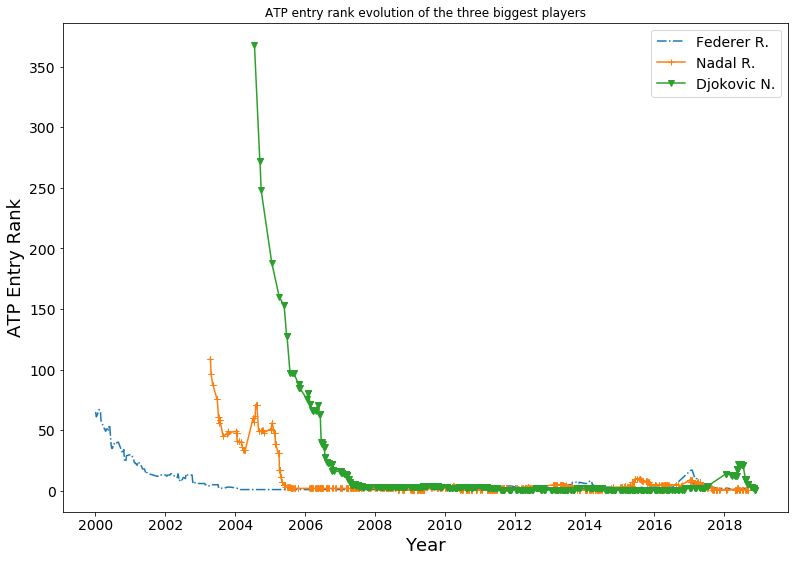

In [232]:
fig = plt.figure(figsize=(13, 9))

x, y = rankings(df_atp, 'Federer R.')
plt.plot_date(x, y, '-.')

x, y = rankings(df_atp, 'Nadal R.')
plt.plot_date(x, y, '-+')

x, y = rankings(df_atp, 'Djokovic N.')
plt.plot_date(x, y, '-v')

plt.xlabel('Year', fontsize=18)
plt.ylabel('ATP Entry Rank', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['Federer R.', 'Nadal R.', 'Djokovic N.'], fontsize=14)
plt.title('ATP entry rank evolution of the three biggest players')
plt.show()

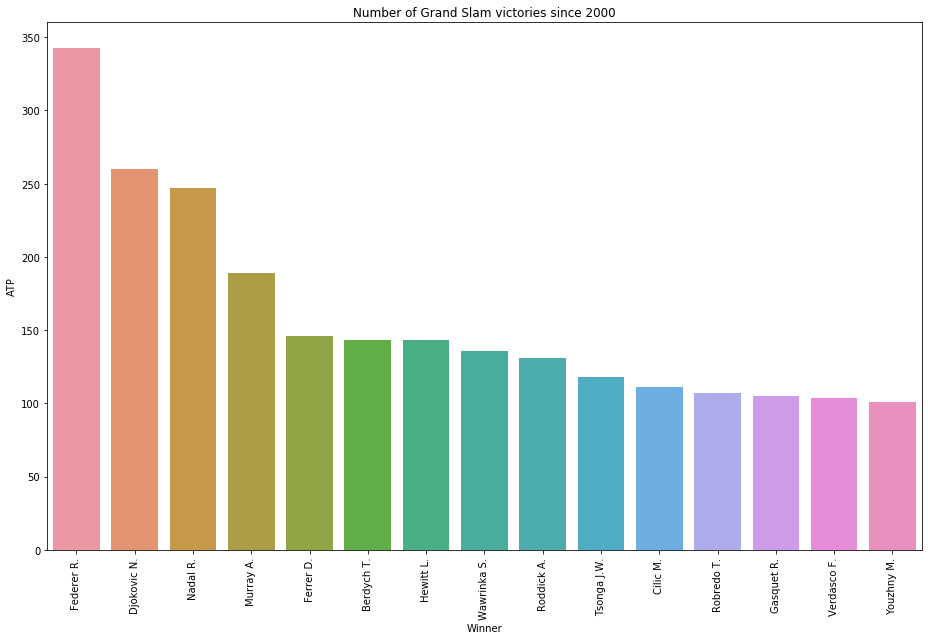

In [234]:
# number of Grand Slam victories by player (first 15 players)

df_gs = df_atp[df_atp.Series == 'Grand Slam'].groupby(['Winner']).agg({
    'ATP':'count'}).sort_values(by='ATP', ascending=False).iloc[0:15]

fig, ax = plt.subplots(figsize=(13,9))
ax = sns.barplot(x=df_gs.index, y=df_gs.ATP)
ax.set_xticklabels(labels=df_gs.index, rotation=90)
ax.set(title='Number of Grand Slam victories since 2000')
ax.figure.tight_layout()

#fig.savefig(fig_dir+"grand_slam.png")
plt.show()

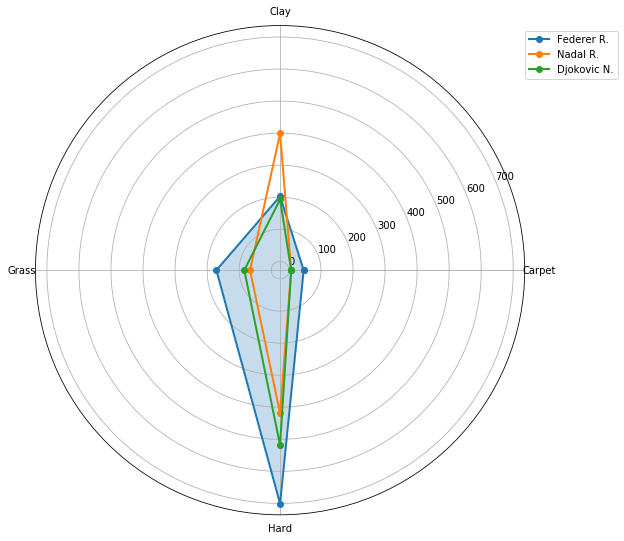

In [235]:
#Surface impact on players
df_sur = df_atp.groupby(['Winner', 'Surface']).agg({'ATP':'count'})
df_FR = df_sur.loc['Federer R.']
df_NR = df_sur.loc['Nadal R.']
df_DN = df_sur.loc['Djokovic N.']


labels = df_FR.index
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
angles = np.concatenate((angles,[angles[0]]))
FR = np.concatenate((df_FR.ATP,[df_FR.ATP[0]]))
NR = np.concatenate((df_NR.ATP,[df_NR.ATP[0]]))
DN = np.concatenate((df_DN.ATP,[df_DN.ATP[0]]))

fig = plt.figure(figsize=(13,9))
ax = fig.add_subplot(111, polar=True)
ax.plot(angles, FR, 'o-', linewidth=2, label='Federer R.')
ax.plot(angles, NR, 'o-', linewidth=2, label='Nadal R.')
ax.plot(angles, DN, 'o-', linewidth=2, label='Djokovic N.')
ax.fill(angles, FR, alpha=0.25)
ax.set_thetagrids(angles * 180/np.pi, labels)
ax.grid(True)
plt.legend(loc='upper right', bbox_to_anchor=(1.2,1))

#fig.savefig(fig_dir+"surface_effect.png")
plt.show()